In [137]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
import statsmodels.stats as stat
import sys
# import talib
import scipy.stats as stat
import sympy as sy
from sympy.stats import Normal, cdf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
import sklearn
import joblib
import pickle
#import pickle5 as pickle
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

In [161]:
data_path = '/Users/chenwynn/Documents/Intern_project/HTSC_Summer/team/SabrSummerProject2022'
feature_train = pd.read_csv(os.path.join(data_path, 'feature_train.csv'), index_col = 0)
feature_test = pd.read_csv(os.path.join(data_path, 'feature_test.csv'), index_col = 0)

In [172]:
raw_feature_list = [ 'open', 'high', 'low', 'close', 'volume', 'strike', 'strike price', 'time_to_mature',
       'spot price', 'black vol', 'sabr vol', 'delta', 'vega', 'theta',
       'gamma', 'riskfree rate', 'C', 'P', 'sabr_value', 'close_ma_5min',
       'close_ma_15min', 'close_ema_5min', 'close_ema_15min',
       'close_ma_diff_5', 'close_ema_diff_5', 'volume_ema_10min',
       'volume_ema_30min', 'volume_ema_diff', 'vol_diff', 'moneyness',
       'sabr_value_diff']
X_train_raw = feature_train[raw_feature_list]
X_test_raw = feature_test[raw_feature_list]

In [173]:
import lightgbm as lgb
import sklearn as sk

In [174]:
import joblib
lgb_model = joblib.load(os.path.join(data_path, '02_src/Backtest/best_lgbm_model_ret.pkl'))

In [184]:
feature_train['model return'] = lgb_model.predict(X_train_raw)
feature_test['model return'] = lgb_model.predict(X_test_raw)

In [192]:
sabr2207 = pd.concat([feature_train, feature_test])
sabr2207['time'] = pd.to_datetime(sabr2207['time'])
sabr2207['signal'] = -sabr2207['close'] * sabr2207['model return']
sabr2207[['signal','delta', 'vega', 'gamma', 'theta']] = sabr2207.groupby('code')[['signal','delta', 'vega', 'gamma', 'theta']].shift()
sabr2207 = sabr2207.sort_values(['time', 'code'])

In [193]:
path = '/Users/chenwynn/Documents/Intern_project/HTSC_Summer/sabr_vol'
sys.path.append(path)
import hedge_update

f = open(os.path.join(data_path, '03_data/300etf.pkl'),'rb')
etf = pickle.load(f)
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

In [194]:
param_dict_ = {'by_rank':2, 'symmetry':True}
# param_dict_ = {'bar':1e-3}
strat = sabr2207.groupby('time').apply(hedge_update.Option_Split_Rank, **param_dict_)
pcpl1 = hedge_update.Hedge_Transform(strat, etf)
hedge_update.Global_Exist(pcpl1)
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Option_Position_Add).reset_index(drop = True)
# temp.to_csv('/Users/chenwynn/Documents/Intern_project/HTSC_Summer/sabr_vol/add.csv')
hedge_update.Global_Exist(pcpl1)
hedge_dict_ = {'bar':8e-4, 'delta_tolerance':5, 'vega_tolerance':5}
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Vega, **hedge_dict_).reset_index(drop = True)

pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

my bars::   1%|          | 20/1993 [00:00<00:20, 96.65it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   2%|▏         | 40/1993 [00:00<00:21, 89.26it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   3%|▎         | 62/1993 [00:00<00:19, 97.50it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   4%|▍         | 82/1993 [00:00<00:23, 81.63it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   5%|▌         | 100/1993 [00:01<00:22, 84.01it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   6%|▌         | 121/1993 [00:01<00:20, 92.85it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   7%|▋         | 141/1993 [00:01<00:20, 91.39it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   8%|▊         | 151/1993 [00:01<00:22, 80.52it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   8%|▊         | 168/1993 [00:01<00:24, 73.01it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   9%|▉         | 186/1993 [00:02<00:23, 76.72it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  10%|█         | 203/1993 [00:02<00:23, 74.83it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  11%|█         | 219/1993 [00:02<00:25, 69.47it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  12%|█▏        | 239/1993 [00:02<00:21, 82.19it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  13%|█▎        | 258/1993 [00:03<00:22, 77.24it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  14%|█▎        | 274/1993 [00:03<00:24, 70.90it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  15%|█▍        | 291/1993 [00:03<00:22, 74.28it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  16%|█▌        | 311/1993 [00:03<00:21, 76.90it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  16%|█▋        | 327/1993 [00:04<00:23, 71.67it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  17%|█▋        | 342/1993 [00:04<00:24, 67.04it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  18%|█▊        | 356/1993 [00:04<00:24, 66.26it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  19%|█▊        | 370/1993 [00:04<00:24, 65.31it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  19%|█▉        | 384/1993 [00:05<00:25, 63.11it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  20%|██        | 399/1993 [00:05<00:23, 66.71it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  21%|██        | 414/1993 [00:05<00:23, 66.80it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  21%|██▏       | 428/1993 [00:05<00:23, 65.43it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  22%|██▏       | 442/1993 [00:05<00:23, 65.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  23%|██▎       | 461/1993 [00:06<00:20, 72.98it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  24%|██▍       | 476/1993 [00:06<00:22, 67.98it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  25%|██▍       | 490/1993 [00:06<00:22, 65.82it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  25%|██▌       | 505/1993 [00:06<00:21, 70.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  26%|██▌       | 521/1993 [00:07<00:21, 69.06it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 535/1993 [00:07<00:21, 67.40it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  28%|██▊       | 550/1993 [00:07<00:21, 68.26it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  28%|██▊       | 565/1993 [00:07<00:21, 67.05it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  29%|██▉       | 582/1993 [00:07<00:19, 71.08it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  30%|███       | 598/1993 [00:08<00:19, 71.97it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  31%|███       | 614/1993 [00:08<00:19, 71.35it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  32%|███▏      | 630/1993 [00:08<00:19, 70.19it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  32%|███▏      | 646/1993 [00:08<00:18, 71.90it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  33%|███▎      | 662/1993 [00:09<00:19, 69.99it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  34%|███▍      | 677/1993 [00:09<00:19, 68.58it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  35%|███▍      | 691/1993 [00:09<00:19, 67.23it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  35%|███▌      | 705/1993 [00:09<00:19, 64.89it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  36%|███▌      | 719/1993 [00:09<00:19, 66.07it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  37%|███▋      | 733/1993 [00:10<00:20, 61.60it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  38%|███▊      | 748/1993 [00:10<00:19, 65.08it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  38%|███▊      | 762/1993 [00:10<00:18, 64.88it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  39%|███▉      | 776/1993 [00:10<00:19, 61.78it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  40%|███▉      | 790/1993 [00:11<00:20, 59.33it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  40%|████      | 803/1993 [00:11<00:20, 58.26it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  41%|████      | 815/1993 [00:11<00:20, 58.40it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  42%|████▏     | 828/1993 [00:11<00:19, 58.95it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  42%|████▏     | 842/1993 [00:11<00:19, 60.36it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  43%|████▎     | 856/1993 [00:12<00:18, 62.32it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  44%|████▎     | 870/1993 [00:12<00:17, 64.10it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  44%|████▍     | 885/1993 [00:12<00:16, 66.22it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  45%|████▌     | 901/1993 [00:12<00:15, 70.32it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  46%|████▌     | 916/1993 [00:13<00:16, 67.06it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  47%|████▋     | 931/1993 [00:13<00:16, 66.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  48%|████▊     | 948/1993 [00:13<00:15, 68.67it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  48%|████▊     | 962/1993 [00:13<00:15, 68.37it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  49%|████▉     | 976/1993 [00:13<00:15, 67.69it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  50%|████▉     | 992/1993 [00:14<00:14, 71.00it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  51%|█████     | 1008/1993 [00:14<00:13, 70.63it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  51%|█████▏    | 1023/1993 [00:14<00:14, 68.90it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  52%|█████▏    | 1040/1993 [00:14<00:12, 74.98it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  53%|█████▎    | 1056/1993 [00:15<00:12, 72.52it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  54%|█████▍    | 1072/1993 [00:15<00:12, 73.99it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  55%|█████▍    | 1088/1993 [00:15<00:12, 74.39it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  55%|█████▌    | 1104/1993 [00:15<00:12, 73.16it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  56%|█████▌    | 1120/1993 [00:15<00:12, 70.81it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  57%|█████▋    | 1136/1993 [00:16<00:12, 70.91it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  58%|█████▊    | 1151/1993 [00:16<00:12, 67.19it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  58%|█████▊    | 1165/1993 [00:16<00:12, 67.84it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  59%|█████▉    | 1179/1993 [00:16<00:12, 63.18it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  60%|█████▉    | 1193/1993 [00:17<00:13, 59.77it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  61%|██████    | 1209/1993 [00:17<00:11, 66.47it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  61%|██████▏   | 1224/1993 [00:17<00:11, 65.71it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  62%|██████▏   | 1238/1993 [00:17<00:11, 65.22it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  63%|██████▎   | 1253/1993 [00:17<00:10, 69.69it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  64%|██████▎   | 1269/1993 [00:18<00:10, 69.74it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  65%|██████▍   | 1287/1993 [00:18<00:09, 77.75it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  65%|██████▌   | 1303/1993 [00:18<00:09, 74.96it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  66%|██████▌   | 1319/1993 [00:18<00:09, 73.89it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  67%|██████▋   | 1335/1993 [00:19<00:09, 68.71it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  68%|██████▊   | 1351/1993 [00:19<00:08, 72.29it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  69%|██████▊   | 1367/1993 [00:19<00:08, 72.87it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  69%|██████▉   | 1383/1993 [00:19<00:08, 73.89it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  70%|███████   | 1399/1993 [00:19<00:08, 73.23it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  71%|███████   | 1417/1993 [00:20<00:07, 79.38it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  72%|███████▏  | 1435/1993 [00:20<00:06, 80.11it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  73%|███████▎  | 1453/1993 [00:20<00:06, 79.49it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  74%|███████▍  | 1471/1993 [00:20<00:06, 81.92it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  75%|███████▍  | 1488/1993 [00:21<00:06, 77.56it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  75%|███████▌  | 1504/1993 [00:21<00:06, 76.69it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  76%|███████▋  | 1521/1993 [00:21<00:06, 76.14it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  77%|███████▋  | 1537/1993 [00:21<00:06, 74.56it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  78%|███████▊  | 1553/1993 [00:21<00:05, 74.62it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  79%|███████▊  | 1569/1993 [00:22<00:05, 73.49it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  80%|███████▉  | 1588/1993 [00:22<00:04, 81.07it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  81%|████████  | 1606/1993 [00:22<00:04, 79.75it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  81%|████████▏ | 1624/1993 [00:22<00:04, 82.22it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  82%|████████▏ | 1642/1993 [00:22<00:04, 81.28it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  83%|████████▎ | 1661/1993 [00:23<00:03, 83.45it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  84%|████████▍ | 1679/1993 [00:23<00:03, 83.28it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  85%|████████▌ | 1697/1993 [00:23<00:03, 81.72it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  86%|████████▋ | 1719/1993 [00:23<00:03, 89.65it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  87%|████████▋ | 1739/1993 [00:24<00:02, 92.24it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  88%|████████▊ | 1759/1993 [00:24<00:02, 90.23it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  89%|████████▉ | 1779/1993 [00:24<00:02, 88.90it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  91%|█████████ | 1806/1993 [00:24<00:01, 103.64it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  92%|█████████▏| 1827/1993 [00:25<00:01, 93.02it/s] 

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  93%|█████████▎| 1850/1993 [00:25<00:01, 98.81it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  94%|█████████▍| 1874/1993 [00:25<00:01, 100.35it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  96%|█████████▌| 1909/1993 [00:25<00:00, 128.49it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  99%|█████████▉| 1977/1993 [00:25<00:00, 197.73it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars:: 100%|██████████| 1993/1993 [00:26<00:00, 74.87it/s] 


In [195]:
time0 = pcpl1['time'].sort_values().iloc[0]
timen = pcpl1['time'].sort_values().iloc[-1]

# 开仓价为上一个tick的close
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

pcpl1['profit_position_diff'] = pcpl1.groupby('code')['profit_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'profit_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'profit_position']
# pcpl1.loc[pcpl1['time'] == timen, 'cash_diff'] = pcpl1.loc[pcpl1['time'] == timen, 'position'] * pcpl1.loc[pcpl1['time'] == timen, 'close']
pcpl1['profit_cost'] = np.abs(pcpl1['profit_position_diff']) * 1.3
pcpl1.loc[(pcpl1['position'] < 0)&(pcpl1['profit_position_diff'] < 0), 'profit_cost'] = 0

pcpl1['hedge_position_diff'] = pcpl1.groupby('code')['hedge_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'hedge_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'hedge_position']
pcpl1.loc[pcpl1['type'] != 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'hedge_position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'hedge_position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'open price']

pcpl1['position_diff'] = pcpl1.groupby('code')['position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'position']
pcpl1.loc[pcpl1['type'] != 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'open price']


# cash = pcpl1.groupby('time')['cash_diff'].sum()

pcpl1['cash'] = pcpl1['close'] - pcpl1['open price']
pcpl1['cash'] = pcpl1['cash'] * pcpl1['position'] * 10000
pcpl1.loc[pcpl1['type'] == 'C', 'out moneyness'] = (-pcpl1.loc[pcpl1['type'] == 'C', 'close'] + pcpl1.loc[pcpl1['type'] == 'C', 'strike price']).apply(lambda x: max(x, 0))
pcpl1.loc[pcpl1['type'] == 'P', 'out moneyness'] = (pcpl1.loc[pcpl1['type'] == 'P', 'close'] - pcpl1.loc[pcpl1['type'] == 'P', 'strike price']).apply(lambda x: max(x, 0))
pcpl1['margin'] = pcpl1.apply(lambda x:max(-(min(x['open price'] + max(0.12*x['spot price'] - x['out moneyness'], 0.07 * x['strike price']), x['strike price'])) * 1e4 * x['position'], x['open price'] * x['position'] * 1e4), axis = 1)
pcpl1['fund_cost'] = pcpl1['margin'] * 0.04/250/48
pcpl1['fund_cost'] = pcpl1['fund_cost'].fillna(0)
pcpl1['cost'] = pcpl1['cost'].fillna(0)
pcpl1['cash_net'] = pcpl1['cash'] - pcpl1['cost'] - pcpl1['fund_cost']

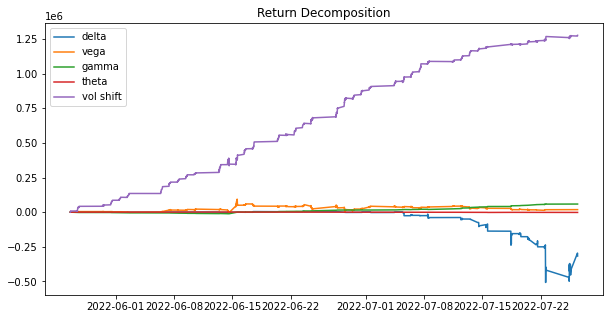

In [196]:
plt.figure(figsize=(10, 5))
plt.title('Return Decomposition')
pcpl1['delta_p'] = pcpl1['delta']*pcpl1['position']
delta_p = pcpl1.groupby('time')['delta_p'].sum()
delta_p = (pcpl1.loc[pcpl1['type'] == 'S', 'close'].diff()).values * delta_p * 1e4
pcpl1['vega_p'] = pcpl1.groupby('code')['sabr vol'].diff()
pcpl1['arbi'] = pcpl1.groupby('code')['black vol'].diff() - pcpl1['vega_p']
pcpl1['arbi'] = pcpl1['arbi'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
pcpl1['vega_p'] = pcpl1['vega_p'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
pcpl1['gamma_p'] = pcpl1['gamma']*pcpl1['position'].values
gamma_p = pcpl1.groupby('time')['gamma_p'].sum()
gamma_p = ((pcpl1.loc[pcpl1['type'] == 'S', 'close'].diff()).values)**2 * gamma_p/2 * 1e4
pcpl1['theta_p'] = pcpl1.groupby('code')['time_to_mature'].diff()
pcpl1['theta_p'] = pcpl1['theta_p'] * pcpl1['theta'].values * pcpl1['position'].values * 1e4
plt.plot(delta_p.cumsum(), label='delta')
plt.plot(pcpl1.groupby('time')['vega_p'].sum().cumsum(), label='vega')
plt.plot(gamma_p.cumsum(), label='gamma')
plt.plot(pcpl1.groupby('time')['theta_p'].sum().cumsum(), label='theta')
plt.plot(pcpl1.groupby('time')['arbi'].sum().cumsum(), label = 'vol shift')
plt.legend()

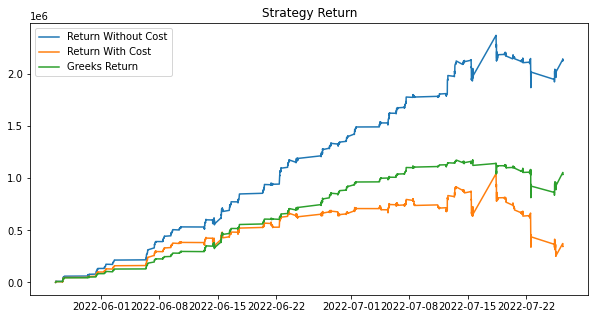

In [197]:
plt.figure(figsize = (10, 5))
plt.title('Strategy Return')
plt.plot(pcpl1.groupby('time')['cash'].sum().cumsum(), label = 'Return Without Cost')
plt.plot(pcpl1.groupby('time')['cash_net'].sum().cumsum(), label = 'Return With Cost')
plt.plot(delta_p.cumsum()+pcpl1.groupby('time')['vega_p'].sum().cumsum()+gamma_p.cumsum()+pcpl1.groupby('time')['theta_p'].sum().cumsum()+pcpl1.groupby('time')['arbi'].sum().cumsum(), label='Greeks Return')
plt.legend()

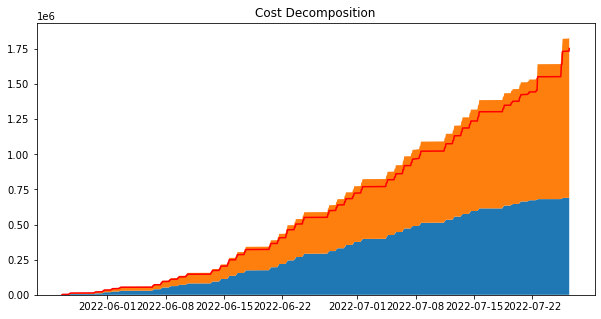

In [198]:
plt.figure(figsize = (10, 5))
plt.title('Cost Decomposition')
plt.stackplot(np.unique(pcpl1['time']), pcpl1.groupby('time')['profit_cost'].sum().cumsum(), pcpl1.groupby('time')['hedge_cost'].sum().cumsum())
plt.plot(pcpl1.groupby('time')['cost'].sum().cumsum(), color='r')

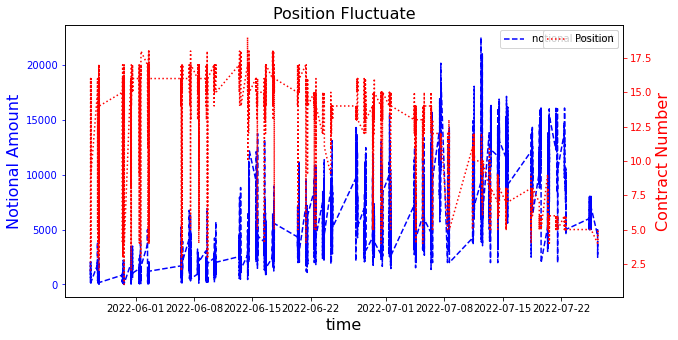

In [199]:
pcpl1['notional'] = np.abs(pcpl1['position'] * pcpl1['spot price'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pcpl1.groupby('time')['notional'].sum(), c='b',ls='--',label='notional amount')
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('Notional Amount', color='b', fontsize=16)
ax.tick_params('y', colors='b')
ax.legend()

ax2 = ax.twinx()
ax2.plot(pcpl1.loc[pcpl1['position'] != 0, :].groupby('time').size(), c='r', ls=":",label='Position')
ax2.set_ylabel('Contract Number',color='r', fontsize=16)
ax2.tick_params('y', colors='r')
ax2.legend()

plt.title('Position Fluctuate', fontsize=16)
plt.show() 

### benchmark

In [154]:
from sabr_bywynn import BlackScholes, SABR

In [155]:
data_path = '/Users/chenwynn/Documents/Intern_project/HTSC_Summer/team/SabrSummerProject2022/03_data'
f = open(os.path.join(data_path, '300etf_2207_sabr_v1.pkl'),'rb')
sabr2207 = pickle.load(f)
sabr2207 = sabr2207.loc[:26173, :]
#f = open(os.path.join(data_path, '300etf_2208_sabr_v1.pkl'),'rb')
#sabr2207 = pickle.load(f)

'''
f = open(os.path.join(data_path, 'greeks_2207_v1.pkl'),'rb')
sabr2207s = pickle.load(f)
sabr2207s = sabr2207s.rename(columns = {'bs_iv':'black vol', 'sabr_iv':'sabr vol', 'strike':'strike price'})
sabr2207s = sabr2207s.reset_index()
'''

f = open(os.path.join(data_path, '300etf.pkl'),'rb')
etf = pickle.load(f)
etf = etf.set_index('time').reindex(pd.Index(np.unique(sabr2207['time']))).reset_index()
etf = etf.rename(columns = {'index':'time'})

'''
volatility spread to generate expected price spread
'''
sabr2207 = sabr2207.loc[(np.abs(sabr2207['delta']) < 0.9)&(np.abs(sabr2207['delta']) > 0.1), :]

def gen_price(x):
    isCall = x['type'].apply(lambda x: True if x == 'C' else False)
    bs = BlackScholes(x['strike price'], x['time_to_mature'].values[0], x['spot price'].values[0], x['riskfree rate'].values[0], isCall)
    x['price'] = bs.black(x['sabr vol'])   
    return x

sabr2207 = sabr2207.groupby('time').apply(gen_price)

#time0 = np.unique(sabr2207['time'])[0]
#time1 = np.unique(sabr2207['time'])[480]
#try1 = sabr2207.loc[(sabr2207['time']>=time0)&(sabr2207['time']<time1), :]
sabr2207['signal'] = sabr2207['close'] - sabr2207['price']
sabr2207[['signal','delta', 'vega', 'gamma', 'theta']] = sabr2207.groupby('code')[['signal','delta', 'vega', 'gamma', 'theta']].shift()

In [156]:
param_dict_ = {'by_rank':2, 'symmetry':True}
# param_dict_ = {'bar':1e-3}
strat = sabr2207.groupby('time').apply(hedge_update.Option_Split_Rank, **param_dict_)
pcpl1 = hedge_update.Hedge_Transform(strat, etf)
hedge_update.Global_Exist(pcpl1)
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Option_Position_Add).reset_index(drop = True)
# temp.to_csv('/Users/chenwynn/Documents/Intern_project/HTSC_Summer/sabr_vol/add.csv')
hedge_update.Global_Exist(pcpl1)
hedge_dict_ = {'bar':8e-4, 'delta_tolerance':5, 'vega_tolerance':5}
pcpl1 = pcpl1.groupby('time').progress_apply(hedge_update.Hedge_Vega, **hedge_dict_).reset_index(drop = True)

pcpl1['position'] = pcpl1['profit_position'] + pcpl1['hedge_position']

# 手续费
time0 = pcpl1['time'].sort_values().iloc[0]
timen = pcpl1['time'].sort_values().iloc[-1]

# 开仓价为上一个tick的close
pcpl1['open price'] = pcpl1.groupby('code')['close'].shift()

pcpl1['profit_position_diff'] = pcpl1.groupby('code')['profit_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'profit_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'profit_position']
# pcpl1.loc[pcpl1['time'] == timen, 'cash_diff'] = pcpl1.loc[pcpl1['time'] == timen, 'position'] * pcpl1.loc[pcpl1['time'] == timen, 'close']
pcpl1['profit_cost'] = np.abs(pcpl1['profit_position_diff']) * 1.3
pcpl1.loc[(pcpl1['position'] < 0)&(pcpl1['profit_position_diff'] < 0), 'profit_cost'] = 0

pcpl1['hedge_position_diff'] = pcpl1.groupby('code')['hedge_position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'hedge_position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'hedge_position']
pcpl1.loc[pcpl1['type'] != 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'hedge_position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'hedge_cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'hedge_position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'hedge_position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['hedge_position'] < 0)&(pcpl1['hedge_position_diff'] < 0), 'open price']

pcpl1['position_diff'] = pcpl1.groupby('code')['position'].diff()
pcpl1.loc[pcpl1['time'] == time0, 'position_diff'] = pcpl1.loc[pcpl1['time'] == time0, 'position']
pcpl1.loc[pcpl1['type'] != 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] != 'S', 'position_diff']) * 1.3
pcpl1.loc[(pcpl1['type'] != 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = 0
pcpl1.loc[pcpl1['type'] == 'S', 'cost'] = np.abs(pcpl1.loc[pcpl1['type'] == 'S', 'position_diff']) * 0.4 * pcpl1.loc[pcpl1['type'] == 'S', 'close']
pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'cost'] = np.abs(pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'position_diff']) * 3 * pcpl1.loc[(pcpl1['type'] == 'S')&(pcpl1['position'] < 0)&(pcpl1['position_diff'] < 0), 'open price']


# cash = pcpl1.groupby('time')['cash_diff'].sum()

pcpl1['cash'] = pcpl1['close'] - pcpl1['open price']
pcpl1['cash'] = pcpl1['cash'] * pcpl1['position'] * 10000
pcpl1.loc[pcpl1['type'] == 'C', 'out moneyness'] = (-pcpl1.loc[pcpl1['type'] == 'C', 'close'] + pcpl1.loc[pcpl1['type'] == 'C', 'strike price']).apply(lambda x: max(x, 0))
pcpl1.loc[pcpl1['type'] == 'P', 'out moneyness'] = (pcpl1.loc[pcpl1['type'] == 'P', 'close'] - pcpl1.loc[pcpl1['type'] == 'P', 'strike price']).apply(lambda x: max(x, 0))
pcpl1['margin'] = pcpl1.apply(lambda x:max(-(min(x['open price'] + max(0.12*x['spot price'] - x['out moneyness'], 0.07 * x['strike price']), x['strike price'])) * 1e4 * x['position'], x['open price'] * x['position'] * 1e4), axis = 1)
pcpl1['fund_cost'] = pcpl1['margin'] * 0.04/250/48
pcpl1['fund_cost'] = pcpl1['fund_cost'].fillna(0)
pcpl1['cost'] = pcpl1['cost'].fillna(0)
pcpl1['cash_net'] = pcpl1['cash'] - pcpl1['cost'] - pcpl1['fund_cost']
# cash = pcpl1.groupby('time')['cash'].sum()

my bars::   1%|          | 23/2016 [00:00<00:18, 105.01it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   2%|▏         | 34/2016 [00:00<00:22, 88.69it/s] 

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   3%|▎         | 54/2016 [00:00<00:23, 82.11it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   4%|▎         | 73/2016 [00:00<00:24, 79.36it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   4%|▍         | 90/2016 [00:01<00:24, 77.89it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   5%|▌         | 106/2016 [00:01<00:25, 75.92it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   6%|▌         | 122/2016 [00:01<00:26, 72.82it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   7%|▋         | 139/2016 [00:01<00:24, 76.57it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   8%|▊         | 157/2016 [00:01<00:24, 76.67it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::   9%|▊         | 173/2016 [00:02<00:24, 74.85it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::   9%|▉         | 189/2016 [00:02<00:25, 71.62it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  10%|█         | 210/2016 [00:02<00:20, 86.94it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  11%|█▏        | 228/2016 [00:02<00:22, 80.20it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  12%|█▏        | 247/2016 [00:03<00:21, 81.55it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  13%|█▎        | 265/2016 [00:03<00:21, 80.47it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  14%|█▍        | 282/2016 [00:03<00:24, 71.92it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  15%|█▍        | 299/2016 [00:03<00:23, 72.95it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  16%|█▌        | 315/2016 [00:04<00:23, 72.93it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  16%|█▋        | 332/2016 [00:04<00:22, 74.93it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  17%|█▋        | 348/2016 [00:04<00:22, 73.96it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  18%|█▊        | 364/2016 [00:04<00:23, 69.51it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  19%|█▉        | 378/2016 [00:04<00:24, 65.73it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  19%|█▉        | 392/2016 [00:05<00:24, 67.65it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  20%|██        | 406/2016 [00:05<00:25, 63.76it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  21%|██        | 421/2016 [00:05<00:23, 67.62it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  22%|██▏       | 435/2016 [00:05<00:23, 68.10it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  22%|██▏       | 450/2016 [00:06<00:22, 70.38it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  23%|██▎       | 467/2016 [00:06<00:20, 75.18it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  24%|██▍       | 485/2016 [00:06<00:19, 79.77it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  25%|██▍       | 501/2016 [00:06<00:20, 73.12it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  26%|██▌       | 516/2016 [00:06<00:21, 68.68it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  26%|██▋       | 530/2016 [00:07<00:21, 68.64it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  27%|██▋       | 545/2016 [00:07<00:20, 70.25it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  28%|██▊       | 563/2016 [00:07<00:19, 73.13it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  29%|██▊       | 579/2016 [00:07<00:19, 74.20it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  30%|██▉       | 595/2016 [00:07<00:18, 76.27it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  30%|███       | 611/2016 [00:08<00:19, 72.54it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  31%|███       | 627/2016 [00:08<00:19, 73.07it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  32%|███▏      | 643/2016 [00:08<00:18, 72.53it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  33%|███▎      | 660/2016 [00:08<00:17, 76.99it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  34%|███▎      | 676/2016 [00:09<00:17, 76.46it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  34%|███▍      | 693/2016 [00:09<00:17, 77.27it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  35%|███▌      | 709/2016 [00:09<00:17, 73.04it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  36%|███▌      | 724/2016 [00:09<00:19, 67.68it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  37%|███▋      | 741/2016 [00:09<00:16, 75.62it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  38%|███▊      | 758/2016 [00:10<00:16, 76.27it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  39%|███▊      | 777/2016 [00:10<00:14, 82.96it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  39%|███▉      | 794/2016 [00:10<00:16, 75.59it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  40%|████      | 810/2016 [00:10<00:16, 71.38it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  41%|████      | 826/2016 [00:11<00:16, 70.21it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  42%|████▏     | 842/2016 [00:11<00:16, 70.31it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  43%|████▎     | 858/2016 [00:11<00:16, 69.66it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  43%|████▎     | 872/2016 [00:11<00:17, 67.01it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  44%|████▍     | 887/2016 [00:12<00:16, 68.56it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  45%|████▍     | 903/2016 [00:12<00:15, 70.22it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  46%|████▌     | 922/2016 [00:12<00:13, 81.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  47%|████▋     | 940/2016 [00:12<00:13, 77.38it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  47%|████▋     | 956/2016 [00:12<00:15, 69.94it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  48%|████▊     | 972/2016 [00:13<00:14, 72.25it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  49%|████▉     | 991/2016 [00:13<00:13, 78.30it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  50%|████▉     | 1007/2016 [00:13<00:13, 74.39it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  51%|█████     | 1024/2016 [00:13<00:13, 74.93it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  52%|█████▏    | 1041/2016 [00:14<00:12, 76.06it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  53%|█████▎    | 1059/2016 [00:14<00:11, 80.68it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  53%|█████▎    | 1077/2016 [00:14<00:11, 80.10it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  54%|█████▍    | 1095/2016 [00:14<00:11, 78.79it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  55%|█████▌    | 1111/2016 [00:14<00:12, 72.02it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  56%|█████▌    | 1128/2016 [00:15<00:12, 71.02it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  57%|█████▋    | 1144/2016 [00:15<00:12, 69.90it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  58%|█████▊    | 1160/2016 [00:15<00:12, 71.23it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  58%|█████▊    | 1175/2016 [00:15<00:12, 68.92it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  59%|█████▉    | 1189/2016 [00:16<00:12, 63.85it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  60%|█████▉    | 1203/2016 [00:16<00:13, 60.59it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  60%|██████    | 1216/2016 [00:16<00:13, 57.98it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  61%|██████    | 1229/2016 [00:16<00:13, 59.11it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  62%|██████▏   | 1243/2016 [00:17<00:13, 58.90it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  62%|██████▎   | 1260/2016 [00:17<00:10, 68.73it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  63%|██████▎   | 1277/2016 [00:17<00:10, 70.32it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  64%|██████▍   | 1293/2016 [00:17<00:10, 69.27it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  65%|██████▍   | 1310/2016 [00:17<00:09, 73.16it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  66%|██████▌   | 1327/2016 [00:18<00:09, 74.21it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  67%|██████▋   | 1343/2016 [00:18<00:09, 73.95it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  67%|██████▋   | 1359/2016 [00:18<00:08, 73.44it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  68%|██████▊   | 1376/2016 [00:18<00:08, 75.75it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  69%|██████▉   | 1397/2016 [00:19<00:06, 88.56it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  70%|███████   | 1415/2016 [00:19<00:07, 85.29it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  71%|███████   | 1433/2016 [00:19<00:07, 80.72it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  72%|███████▏  | 1450/2016 [00:19<00:07, 77.14it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  73%|███████▎  | 1468/2016 [00:19<00:06, 80.13it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  74%|███████▎  | 1485/2016 [00:20<00:07, 73.89it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  74%|███████▍  | 1501/2016 [00:20<00:06, 73.83it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  75%|███████▌  | 1517/2016 [00:20<00:06, 74.44it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  76%|███████▌  | 1535/2016 [00:20<00:06, 77.74it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  77%|███████▋  | 1554/2016 [00:21<00:05, 84.31it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  78%|███████▊  | 1577/2016 [00:21<00:04, 92.49it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  79%|███████▉  | 1598/2016 [00:21<00:04, 95.27it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  80%|████████  | 1619/2016 [00:21<00:04, 96.91it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  81%|████████▏ | 1640/2016 [00:21<00:03, 97.05it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  82%|████████▏ | 1660/2016 [00:22<00:03, 92.15it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  83%|████████▎ | 1681/2016 [00:22<00:03, 95.28it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  84%|████████▍ | 1702/2016 [00:22<00:03, 97.17it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  85%|████████▌ | 1723/2016 [00:22<00:03, 95.20it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  86%|████████▋ | 1743/2016 [00:23<00:02, 93.18it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  88%|████████▊ | 1765/2016 [00:23<00:02, 100.26it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  89%|████████▊ | 1789/2016 [00:23<00:02, 105.39it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  90%|████████▉ | 1811/2016 [00:23<00:02, 99.50it/s] 

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  91%|█████████ | 1836/2016 [00:23<00:01, 101.96it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  92%|█████████▏| 1858/2016 [00:24<00:01, 97.79it/s] 

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  93%|█████████▎| 1882/2016 [00:24<00:01, 107.05it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  95%|█████████▍| 1906/2016 [00:24<00:00, 111.81it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars::  96%|█████████▌| 1930/2016 [00:24<00:00, 113.33it/s]

Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully

my bars::  99%|█████████▉| 1999/2016 [00:25<00:00, 197.52it/s]


Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully
Optimization terminated successfully


my bars:: 100%|██████████| 2016/2016 [00:25<00:00, 79.35it/s] 


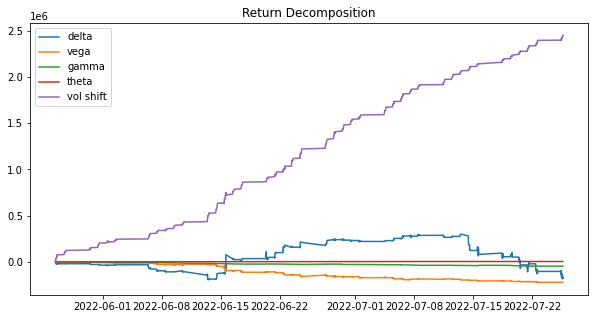

In [157]:
plt.figure(figsize=(10, 5))
plt.title('Return Decomposition')
pcpl1['delta_p'] = pcpl1['delta']*pcpl1['position']
delta_p = pcpl1.groupby('time')['delta_p'].sum()
delta_p = (pcpl1.loc[pcpl1['type'] == 'S', 'close'].diff()).values * delta_p * 1e4
pcpl1['vega_p'] = pcpl1.groupby('code')['sabr vol'].diff()
pcpl1['arbi'] = pcpl1.groupby('code')['black vol'].diff() - pcpl1['vega_p']
pcpl1['arbi'] = pcpl1['arbi'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
pcpl1['vega_p'] = pcpl1['vega_p'] * pcpl1['vega'].values * pcpl1['position'].values * 1e4
pcpl1['gamma_p'] = pcpl1['gamma']*pcpl1['position'].values
gamma_p = pcpl1.groupby('time')['gamma_p'].sum()
gamma_p = ((pcpl1.loc[pcpl1['type'] == 'S', 'close'].diff()).values)**2 * gamma_p/2 * 1e4
pcpl1['theta_p'] = pcpl1.groupby('code')['time_to_mature'].diff()
pcpl1['theta_p'] = pcpl1['theta_p'] * pcpl1['theta'].values * pcpl1['position'].values * 1e4
plt.plot(delta_p.cumsum(), label='delta')
plt.plot(pcpl1.groupby('time')['vega_p'].sum().cumsum(), label='vega')
plt.plot(gamma_p.cumsum(), label='gamma')
plt.plot(pcpl1.groupby('time')['theta_p'].sum().cumsum(), label='theta')
plt.plot(pcpl1.groupby('time')['arbi'].sum().cumsum(), label = 'vol shift')
plt.legend()

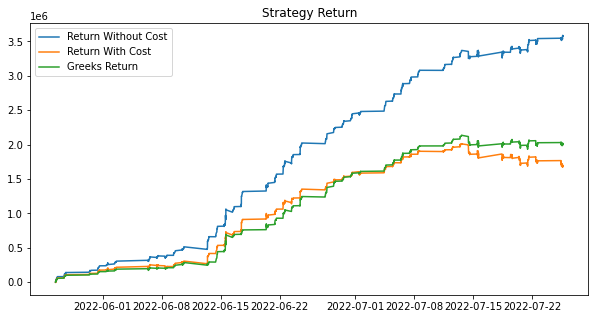

In [158]:
plt.figure(figsize = (10, 5))
plt.title('Strategy Return')
plt.plot(pcpl1.groupby('time')['cash'].sum().cumsum(), label = 'Return Without Cost')
plt.plot(pcpl1.groupby('time')['cash_net'].sum().cumsum(), label = 'Return With Cost')
plt.plot(delta_p.cumsum()+pcpl1.groupby('time')['vega_p'].sum().cumsum()+gamma_p.cumsum()+pcpl1.groupby('time')['theta_p'].sum().cumsum()+pcpl1.groupby('time')['arbi'].sum().cumsum(), label='Greeks Return')
plt.legend()

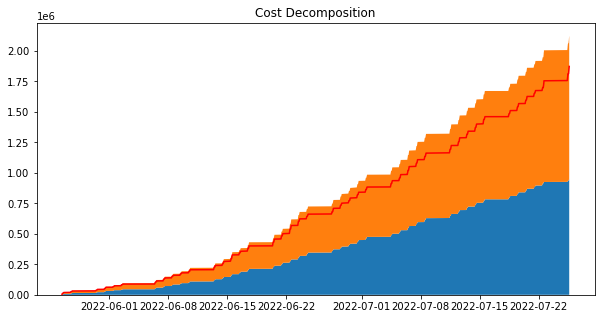

In [159]:
plt.figure(figsize = (10, 5))
plt.title('Cost Decomposition')
plt.stackplot(np.unique(pcpl1['time']), pcpl1.groupby('time')['profit_cost'].sum().cumsum(), pcpl1.groupby('time')['hedge_cost'].sum().cumsum())
plt.plot(pcpl1.groupby('time')['cost'].sum().cumsum(), color='r')

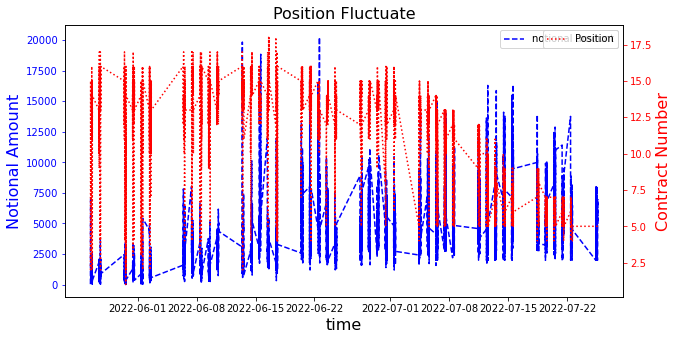

In [160]:
pcpl1['notional'] = np.abs(pcpl1['position'] * pcpl1['spot price'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pcpl1.groupby('time')['notional'].sum(), c='b',ls='--',label='notional amount')
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('Notional Amount', color='b', fontsize=16)
ax.tick_params('y', colors='b')
ax.legend()

ax2 = ax.twinx()
ax2.plot(pcpl1.loc[pcpl1['position'] != 0, :].groupby('time').size(), c='r', ls=":",label='Position')
ax2.set_ylabel('Contract Number',color='r', fontsize=16)
ax2.tick_params('y', colors='r')
ax2.legend()

plt.title('Position Fluctuate', fontsize=16)
plt.show()   